In [47]:
#ライブラリ、モジュールのインポート
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.font_manager as fm
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import re
#import xml.etree.ElementTree as ET

In [48]:
# CSVファイルの読み込み
csv_file = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ).csv'  
df = pd.read_csv(csv_file, encoding='utf-8-sig')

# Excelファイルとして保存
file_path = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)1.xlsx'
df.to_excel(file_path, index=False)

In [52]:
# データの前処理
# Excelファイルの読み込み(公園データ)
file_path = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)1.xlsx'  
df = pd.read_excel(file_path)

# '面積'の列名を'公園面積'に変更
df.rename(columns={'面積': '公園面積'}, inplace=True)

def extract_municipality_custom(address):
    if pd.isna(address) or not isinstance(address, str):
        return ''
    
    if '神奈川県三崎町小網代1023-1' in address:
        return '三浦市'
    
    # 神奈川県の部分を削除
    address = address.replace('神奈川県', '')

    # 特定のパターン「瀬谷区下瀬谷二丁目９番15」の処理
    if '瀬谷区下瀬谷二丁目９番15' in address:
        return '横浜市瀬谷区'

    # 特定の市の場合は区までの記述にする
    for special_city in ['横浜市', '川崎市', '相模原市']:
        if special_city in address:
            return address.split('区')[0] + '区'

    # 通常の市区町村名の抽出
    for keyword in ['市', '町', '村']:
        if keyword in address:
            return address.split(keyword)[0] + keyword

    return address

# D列の住所を変換してE列に保存
df['市区町村'] = df['所在地'].apply(extract_municipality_custom)

# 変更をExcelファイルに保存
output_path = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'  
df.to_excel(output_path, index=False)

In [43]:
#Excelデータのパスを指定
#公園種別、所在地、面積、設備
file_path_1 = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'
# #人口密度、人口総数　　https://www.pref.kanagawa.jp/documents/14449/jinkotosetai_r5_10.xlsxを手動で加工したデータを使用
file_path_2 = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10.xlsx'
# 出力ファイル名の設定
output_filename = '/home/yasumasa-tezuka/intern_data/R1_R5_all_mencho.xlsx'
#https://www.gsi.go.jp/KOKUJYOHO/MENCHO-title.htmよりダウンロードしたR1_R5_all_mencho.csvよりダウンロードしたcsvファイルをExcelファイルに変換
file_path_3 = pd.read_csv('/home/yasumasa-tezuka/intern_data/R1_R5_all_mencho.csv', encoding='cp932')
# Excelファイルに変換して保存
file_path_3.to_excel(output_filename, index=False)
# #行政区域の面積　Excelファイルに変換したR1_R5_all_mencho.xlsxファイルを手動で加工しadministrative_area.xlsxとしてfile_path_3にパスを指定
file_path_3 = '/home/yasumasa-tezuka/intern_data/administrative_area.xlsx'
#フォントのパス
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc' 
# フォントプロパティを設定
font_prop = fm.FontProperties(fname=font_path)
# Matplotlibのデフォルトフォントを更新
plt.rcParams['font.family'] = font_prop.get_name()
# 公園データの読み込み
park_data = pd.read_excel(file_path_1)
#人口密度,人口総数などのデータの読み込み
population_density = pd.read_excel(file_path_2)
#行政区域面積などのデータの読み込み
administrative_area = pd.read_excel(file_path_3)

In [44]:
#140007_park_(神奈川県公園データ)_修正版.xlsxファイルの「面積」の項目を「公園面積」に変更
park_data.rename(columns={'面積': '公園面積'}, inplace=True)
# "公園面積" 列が文字列型の場合は数値型に変換
park_data['公園面積'] = pd.to_numeric(park_data['公園面積'], errors='coerce')

# 変換を適用する列のリスト
# トイレから駐輪場の列を数値型に変換（例: 有=1, 無=0）
columns_to_convert = ['トイレ', '多目的トイレ', '水飲み・手洗い', 'スプリング遊具・スイング遊具', '砂場', '複合遊具', '健康器具', 'ブランコ', 'すべり台', 'ジャングルジム',
                   '鉄棒', 'シーソー', 'ターザンロープ', 'ローラースライダー', 'ふわふわドーム', '芝生広場', '水遊び', 'ランニングコース', 'テニスコート', 'バスケットゴール',
                   '野球場', 'フットサル場', 'サッカー場', 'スケートパーク', 'プール', '体育館', '陸上競技場', 'ウサギ・モルモット', 'ハムスター', 'ひよこ', '馬・ポニー',
                   'カフェ・飲食施設', '売店', '自動販売機', 'バーベキュー場', 'ドッグラン', '喫煙所', 'イベント広場', '避難場所', '無料駐車場', '有料駐車場', '駐輪場']

# 各設備の列の変換処理
for col in columns_to_convert:
    # '-' を 0 に置き換える
    park_data[col] = park_data[col].replace('-', 0)

    # 空欄（NaN）を 0 に置き換える
    park_data[col] = pd.to_numeric(park_data[col], errors='coerce').fillna(0)
    
# 市区町村ごとの公園の数、総面積、平均面積を集計
park_stats = park_data.groupby('市区町村').agg({'No.': 'count', '公園面積': ['sum', 'mean']})
park_stats.columns = ['公園数', '総面積', '平均面積']

# 設備の数を市区町村ごとに集計
facility_stats = park_data.groupby('市区町村')[columns_to_convert].sum()

# 結果の表示
print(park_stats)
print(facility_stats)

          公園数         総面積          平均面積
市区町村                                   
三浦市        64   384977.00   6015.265625
三浦郡葉山町     48   692559.00  14428.312500
中郡二宮町      53   257317.00   4855.037736
中郡大磯町      54   316782.00   5866.333333
伊勢原市      149   400733.00   2689.483221
南足柄市       28   204659.00   7309.250000
厚木市       241  1755292.00   7283.369295
大和市       244   794329.00   3255.446721
小田原市      154  1024883.00   6655.084416
川崎市中原区    109   818671.00   7510.743119
川崎市多摩区    150   446194.00   2974.626667
川崎市宮前区    216  1814565.00   8400.763889
川崎市川崎区    152   685941.00   4512.769737
川崎市幸区     108   401515.00   3717.731481
川崎市高津区    164   647166.00   3946.134146
川崎市麻生区    325  1428938.00   4396.732308
平塚市       282  1023049.00   3653.746429
座間市        46   674596.00  14665.130435
愛甲郡愛川町     22   995034.00  45228.818182
愛甲郡清川村      1    18210.00  18210.000000
横浜市中区      90  1011028.00  11233.644444
横浜市保土ケ谷区  168   993288.00   5912.428571
横浜市南区     131   428747.00   3272.877863


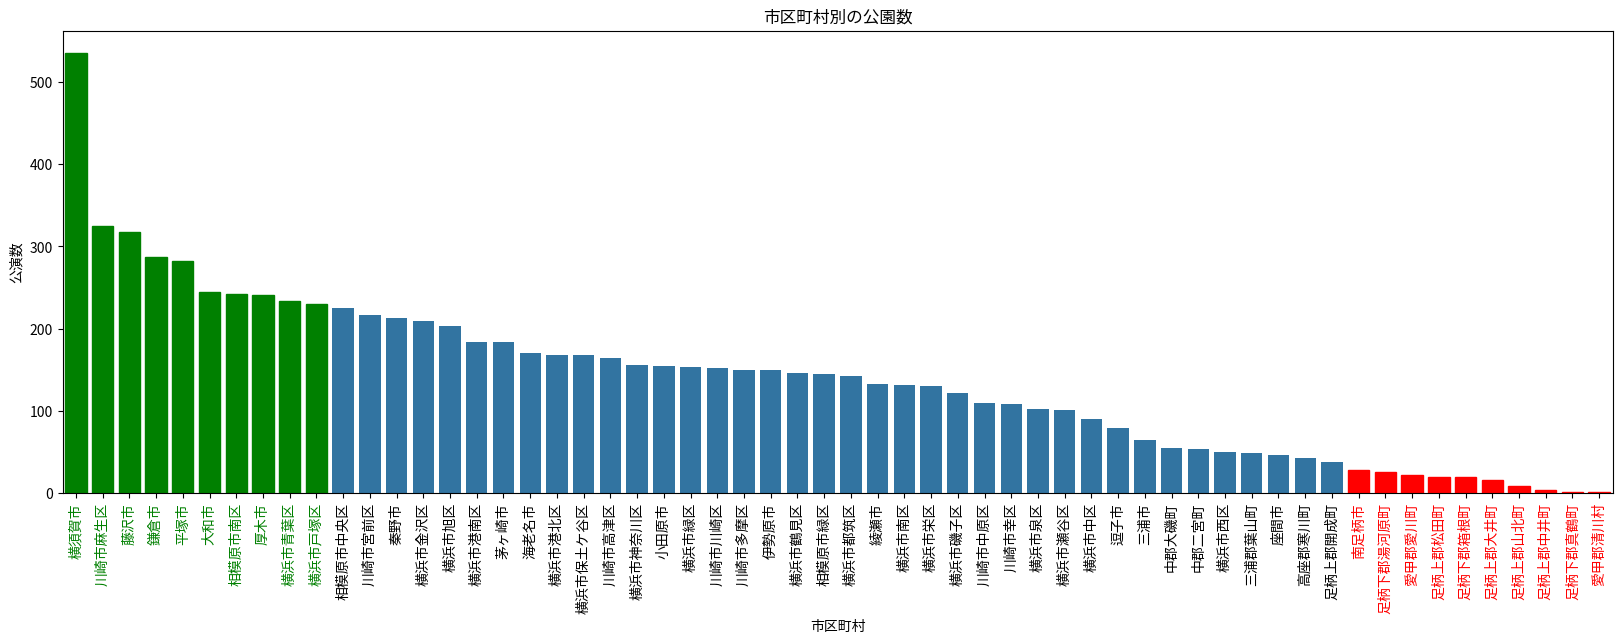

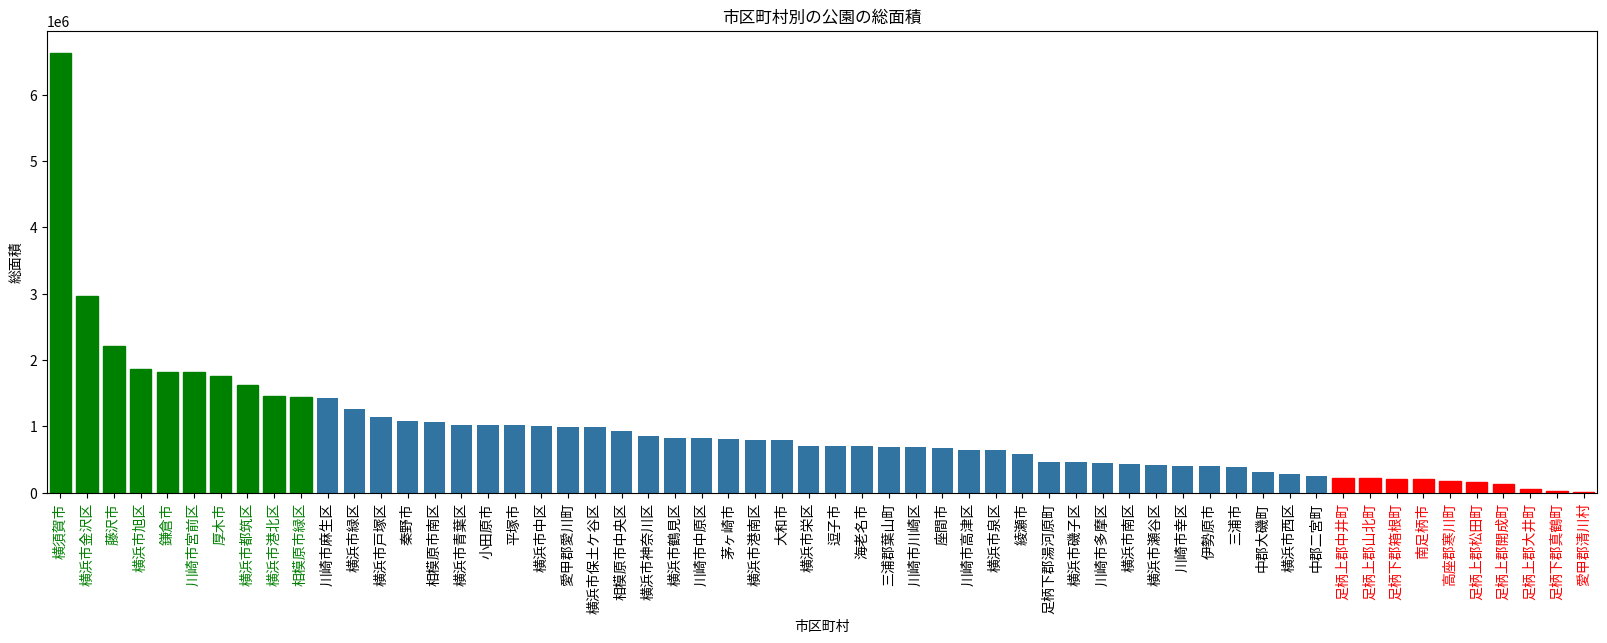

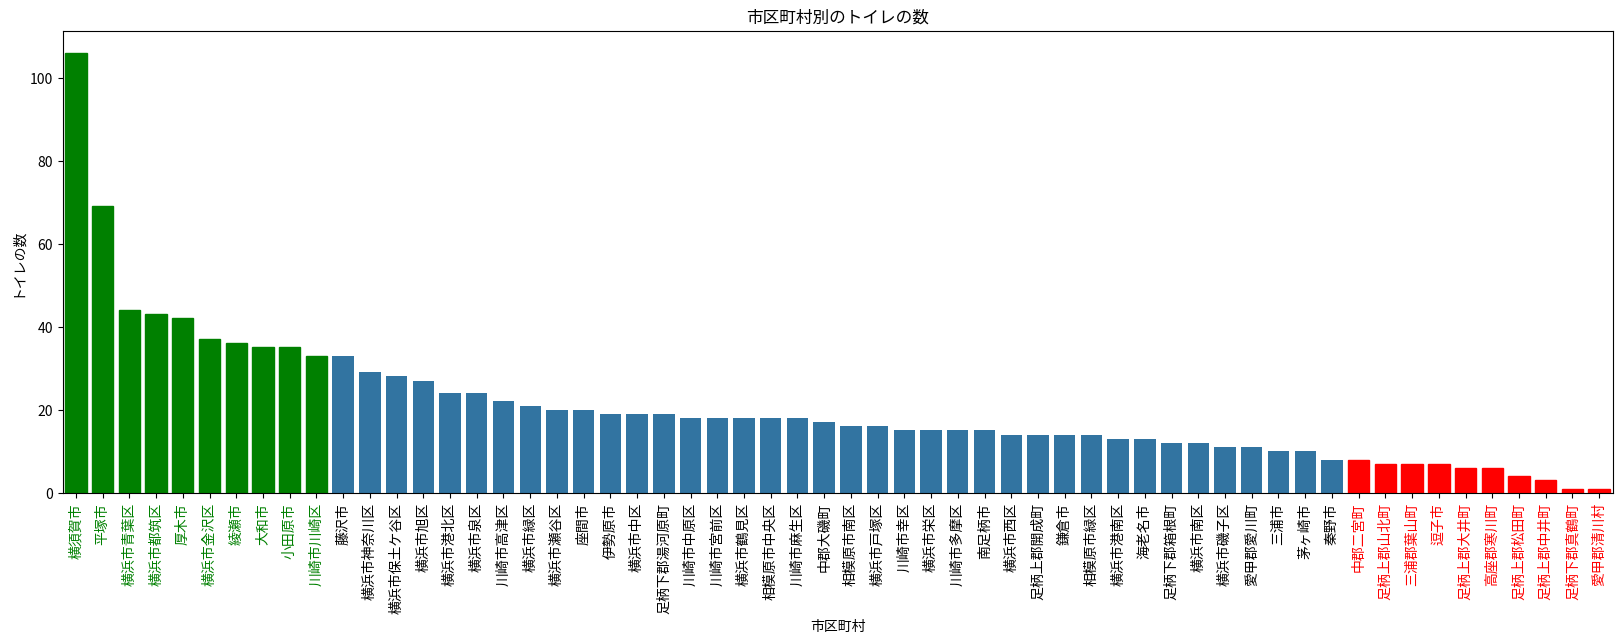

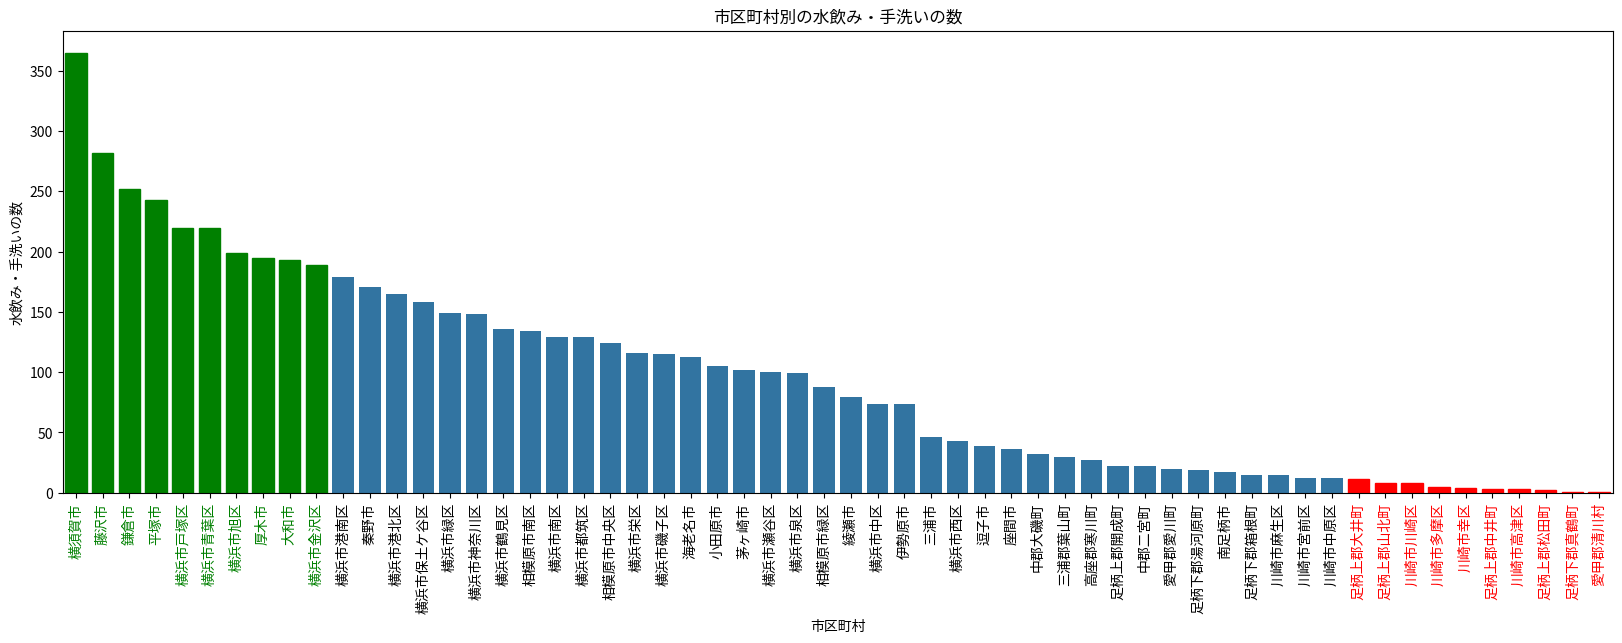

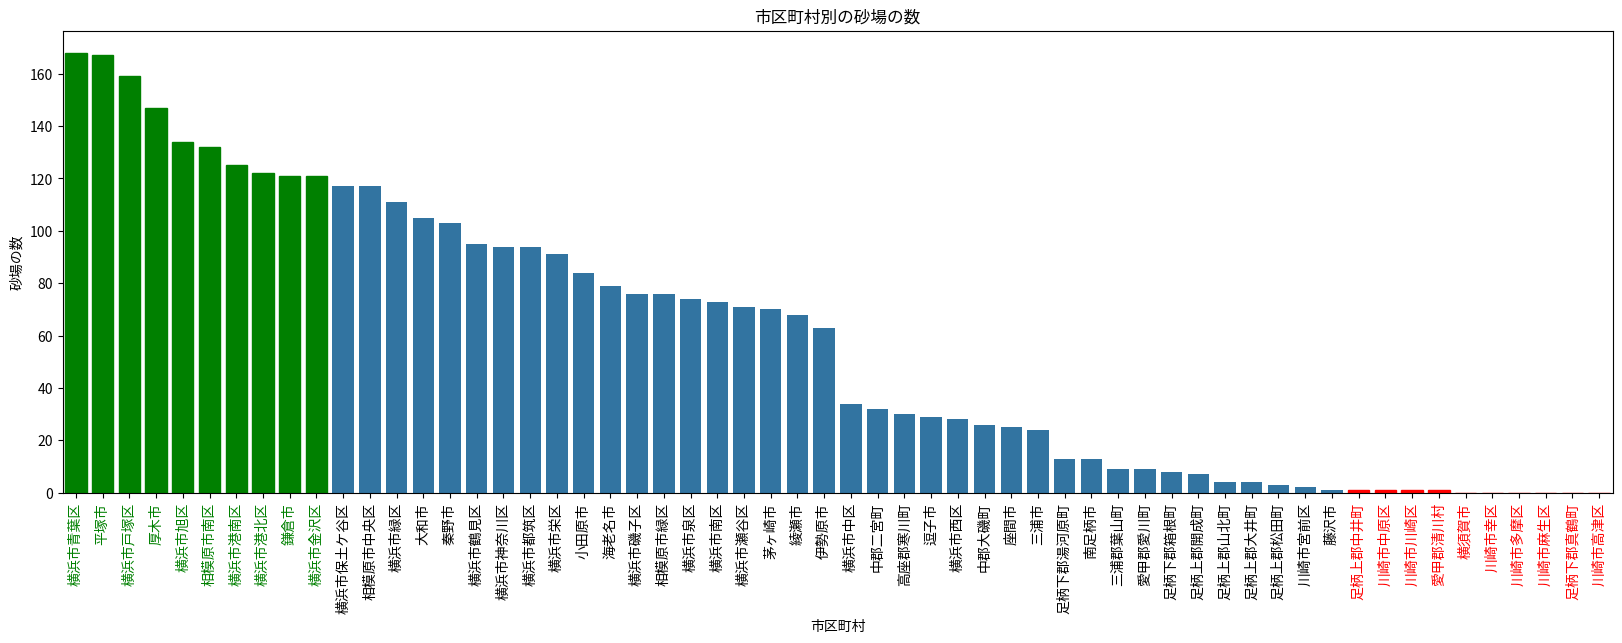

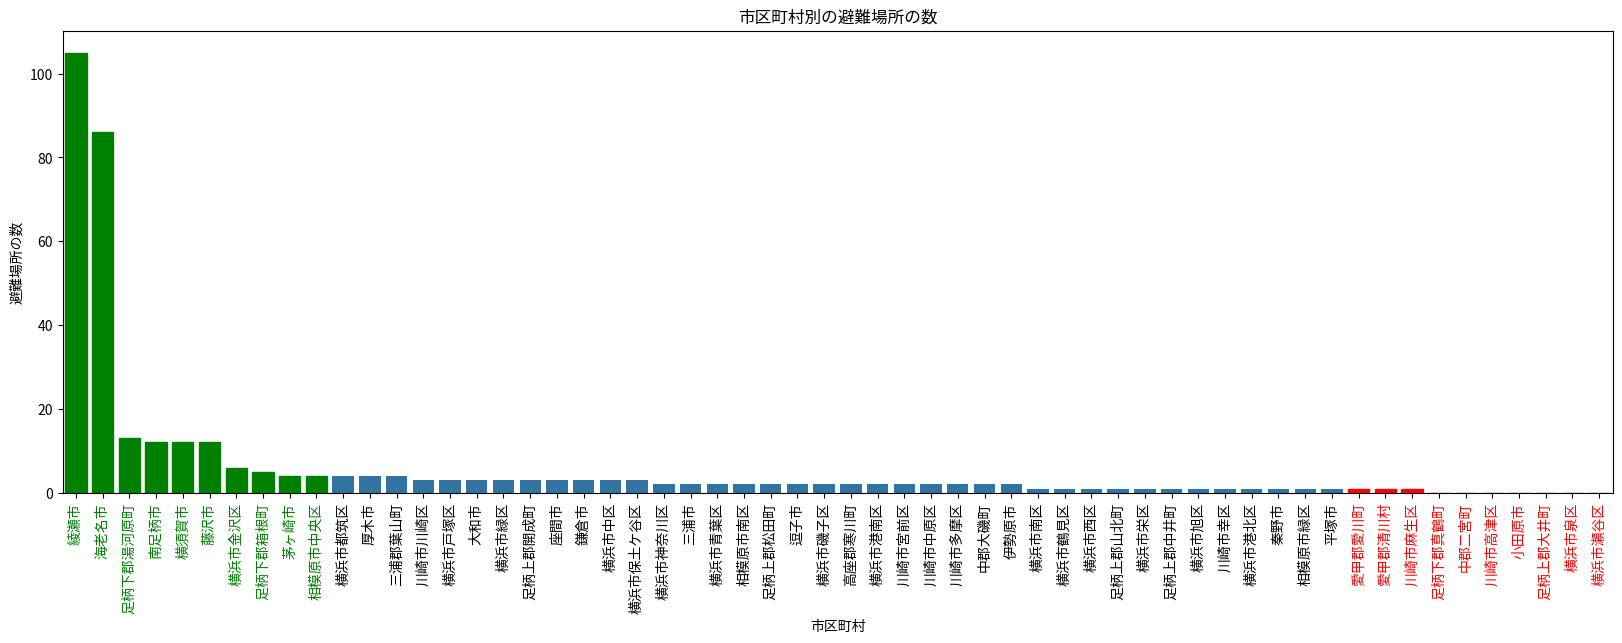

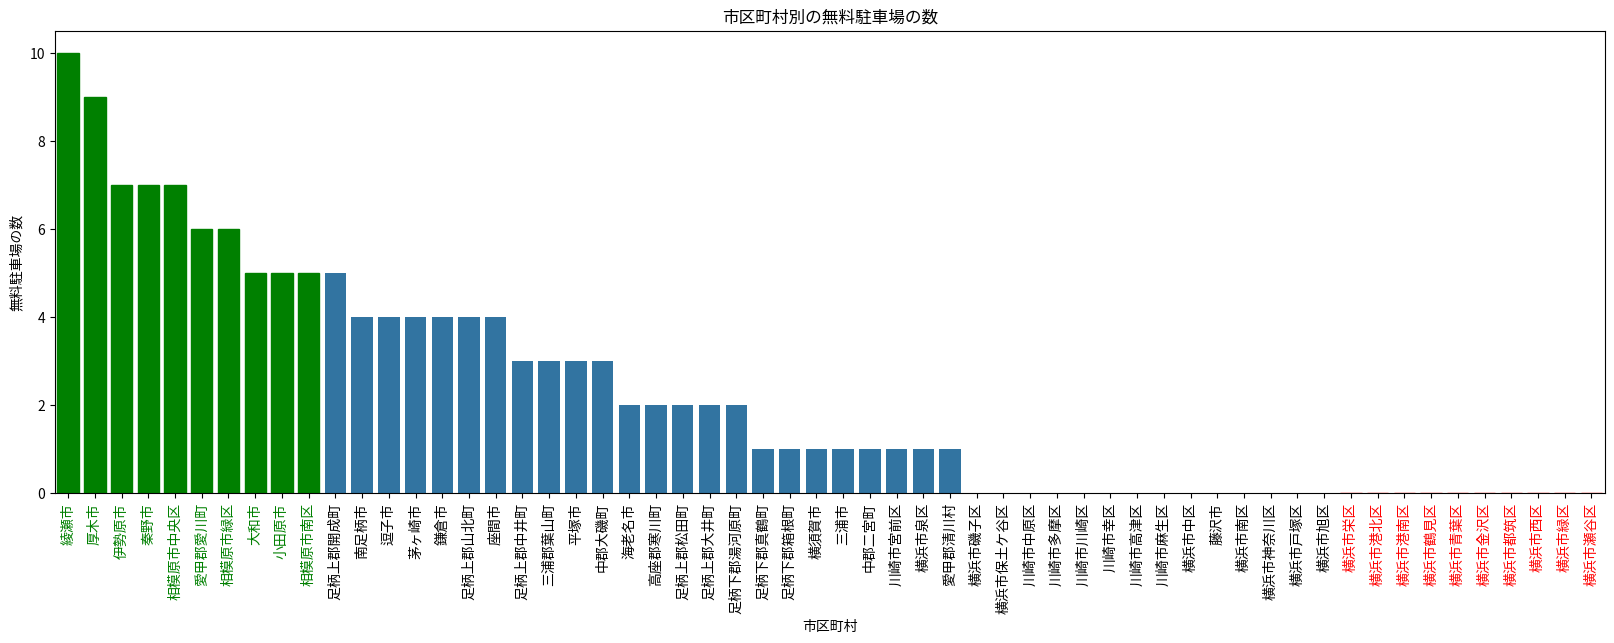

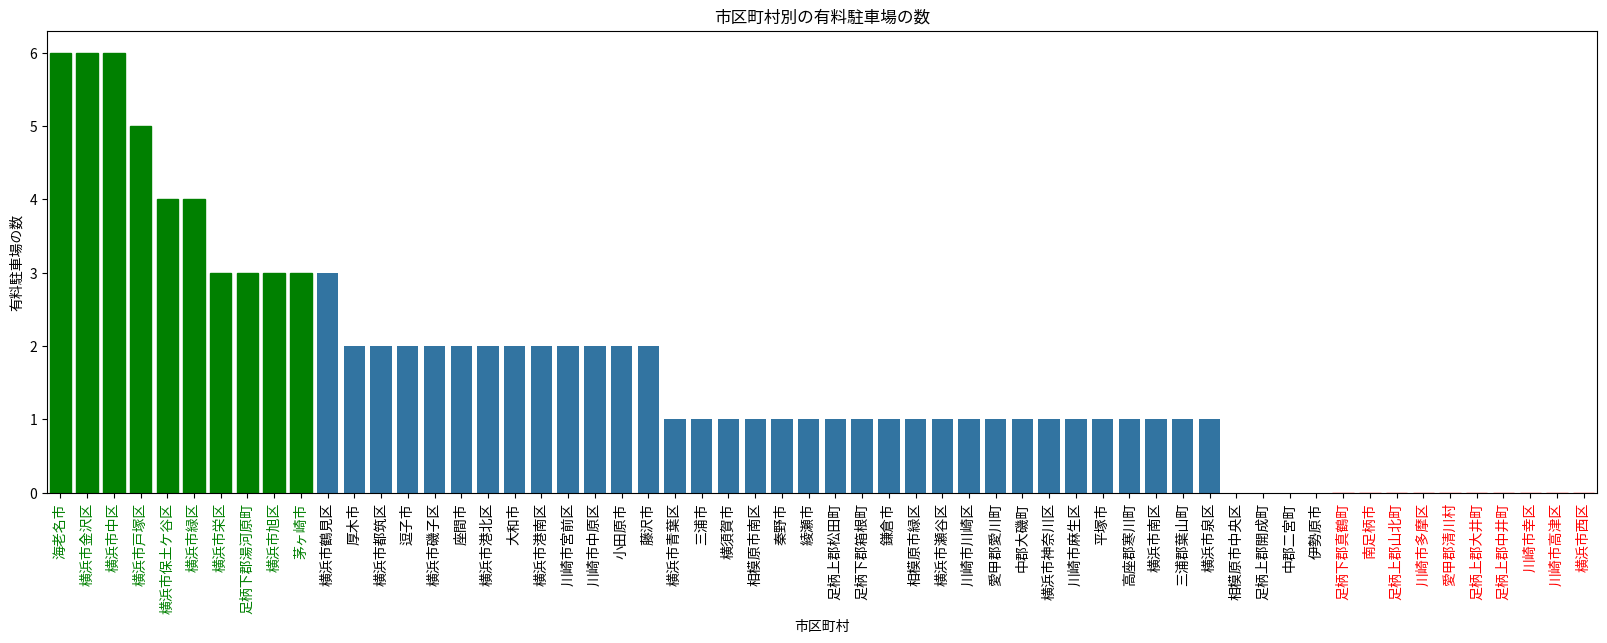

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 公園の数でソート
sorted_park_stats = park_stats.sort_values(by='公園数', ascending=False)

# 値の高い10市区町村と値の低い10市区町村のインデックス取得
top_10 = sorted_park_stats.head(10).index
bottom_10 = sorted_park_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_park_stats.index, y='公園数', data=sorted_park_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い3市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い3市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の公園数')
plt.ylabel('公演数')
plt.show()

#総面積の可視化
# 公園の数でソート
sorted_park_stats = park_stats.sort_values(by='総面積', ascending=False)

# 値の高い10市区町村と値の低い10市区町村のインデックス取得
top_10 = sorted_park_stats.head(10).index
bottom_10 = sorted_park_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_park_stats.index, y='総面積', data=sorted_park_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い3市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い3市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の公園の総面積')
plt.ylabel('総面積')
plt.show()

# 設備：トイレの可視化
# トイレの数でソート
sorted_facility_stats = facility_stats.sort_values(by='トイレ', ascending=False)

# 値の高い10町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='トイレ', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別のトイレの数')
plt.ylabel('トイレの数')
plt.show()

# 設備：水飲み・手洗いの可視化
# 水飲み・手洗いの数でソート
sorted_facility_stats = facility_stats.sort_values(by='水飲み・手洗い', ascending=False)

# 値の高い10市区町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='水飲み・手洗い', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の水飲み・手洗いの数')
plt.ylabel('水飲み・手洗いの数')
plt.show()

# 設備：砂場の可視化
# 砂場の数でソート
sorted_facility_stats = facility_stats.sort_values(by='砂場', ascending=False)

# 値の高い10市区町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='砂場', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の砂場の数')
plt.ylabel('砂場の数')
plt.show()

# 避難場所の可視化
# 避難場所の数でソート
sorted_facility_stats = facility_stats.sort_values(by='避難場所', ascending=False)

# 値の高い10市区町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='避難場所', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の避難場所の数')
plt.ylabel('避難場所の数')
plt.show()

# 設備：無料駐車場の可視化
# 無料駐車場の数でソート
sorted_facility_stats = facility_stats.sort_values(by='無料駐車場', ascending=False)

# 値の高い10町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='無料駐車場', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の無料駐車場の数')
plt.ylabel('無料駐車場の数')
plt.show()

# 設備：有料駐車場の可視化
# 有料駐車場の数でソート
sorted_facility_stats = facility_stats.sort_values(by='有料駐車場', ascending=False)

# 値の高い10町村と値の低い10市区町村のインデックス取得
top_10 = sorted_facility_stats.head(10).index
bottom_10 = sorted_facility_stats.tail(10).index

# 可視化
plt.figure(figsize=(20, 6))
barplot = sns.barplot(x=sorted_facility_stats.index, y='有料駐車場', data=sorted_facility_stats)

# 特定のバーと対応するラベルの色を変更
for idx, label in enumerate(barplot.get_xticklabels()):
    text = label.get_text()
    if text in top_10:
        barplot.patches[idx].set_color('green')  # 値の高い市区町村のバーの色
        label.set_color('green')  # ラベルの色
    elif text in bottom_10:
        barplot.patches[idx].set_color('red')  # 値の低い市区町村のバーの色
        label.set_color('red')  # ラベルの色

plt.xticks(rotation=90)
plt.title('市区町村別の有料駐車場の数')
plt.ylabel('有料駐車場の数')
plt.show()


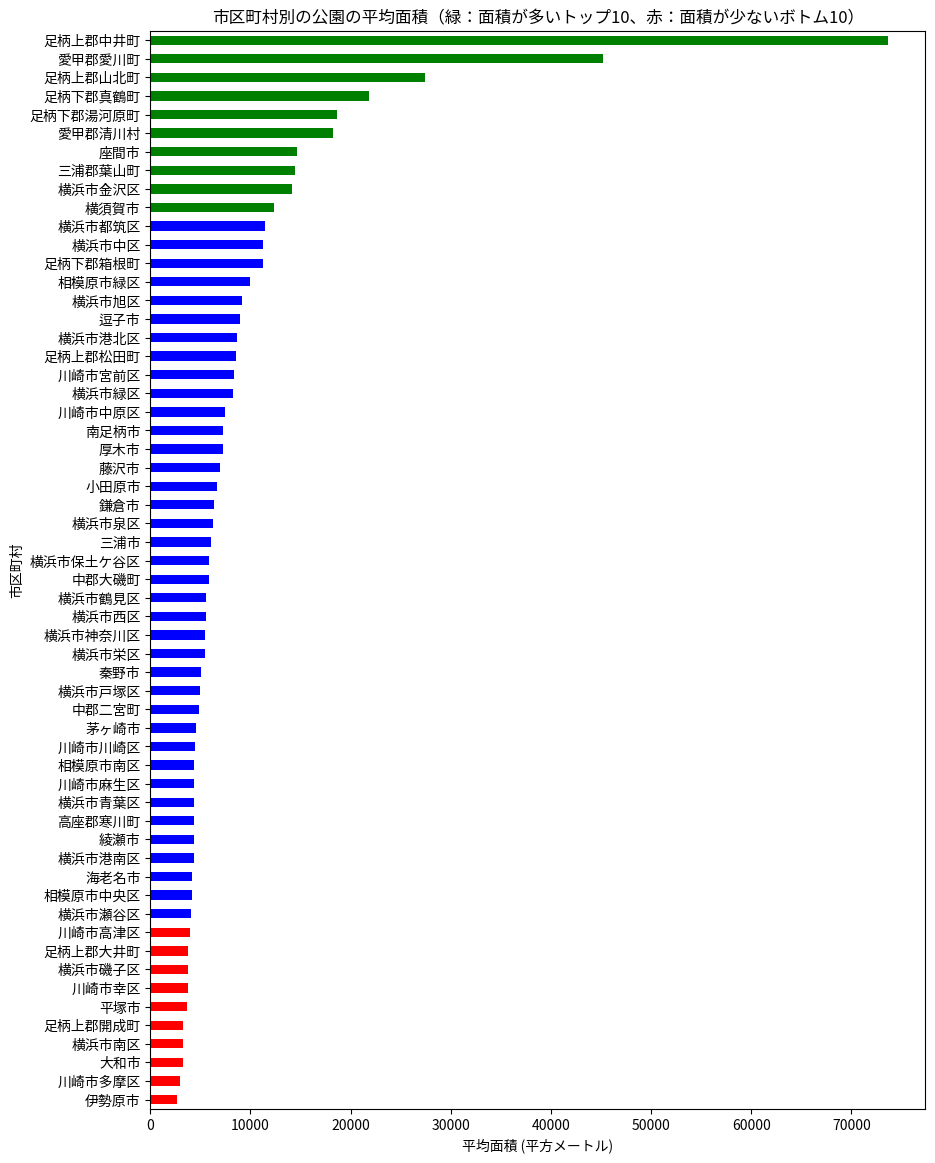

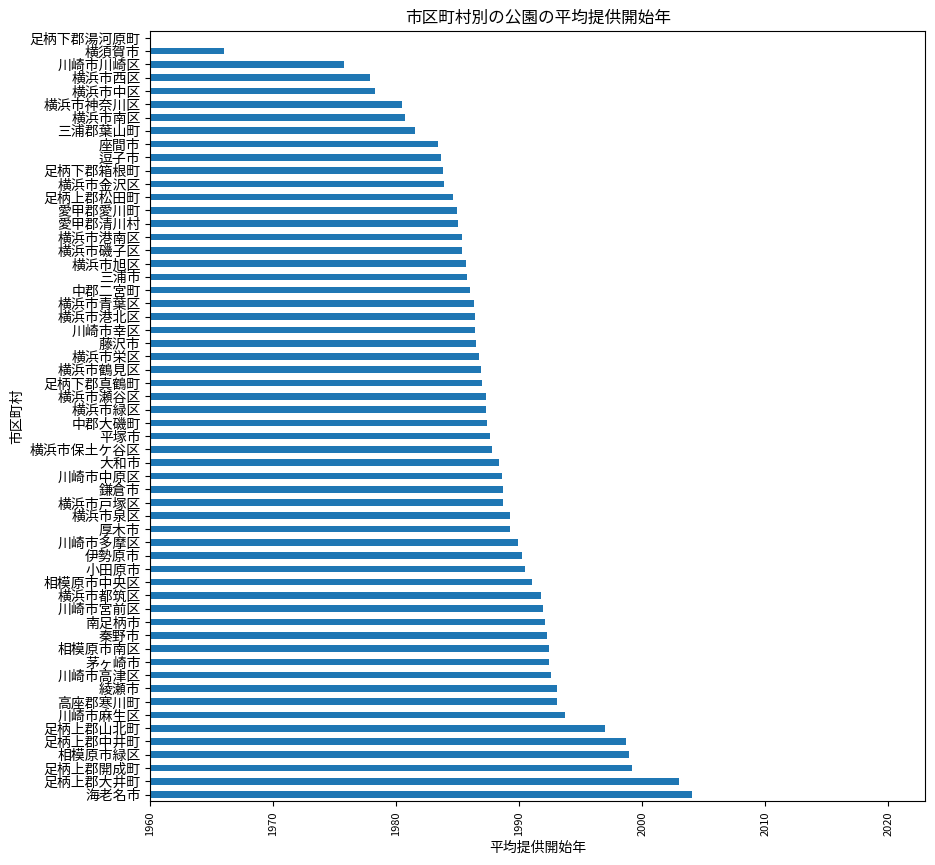

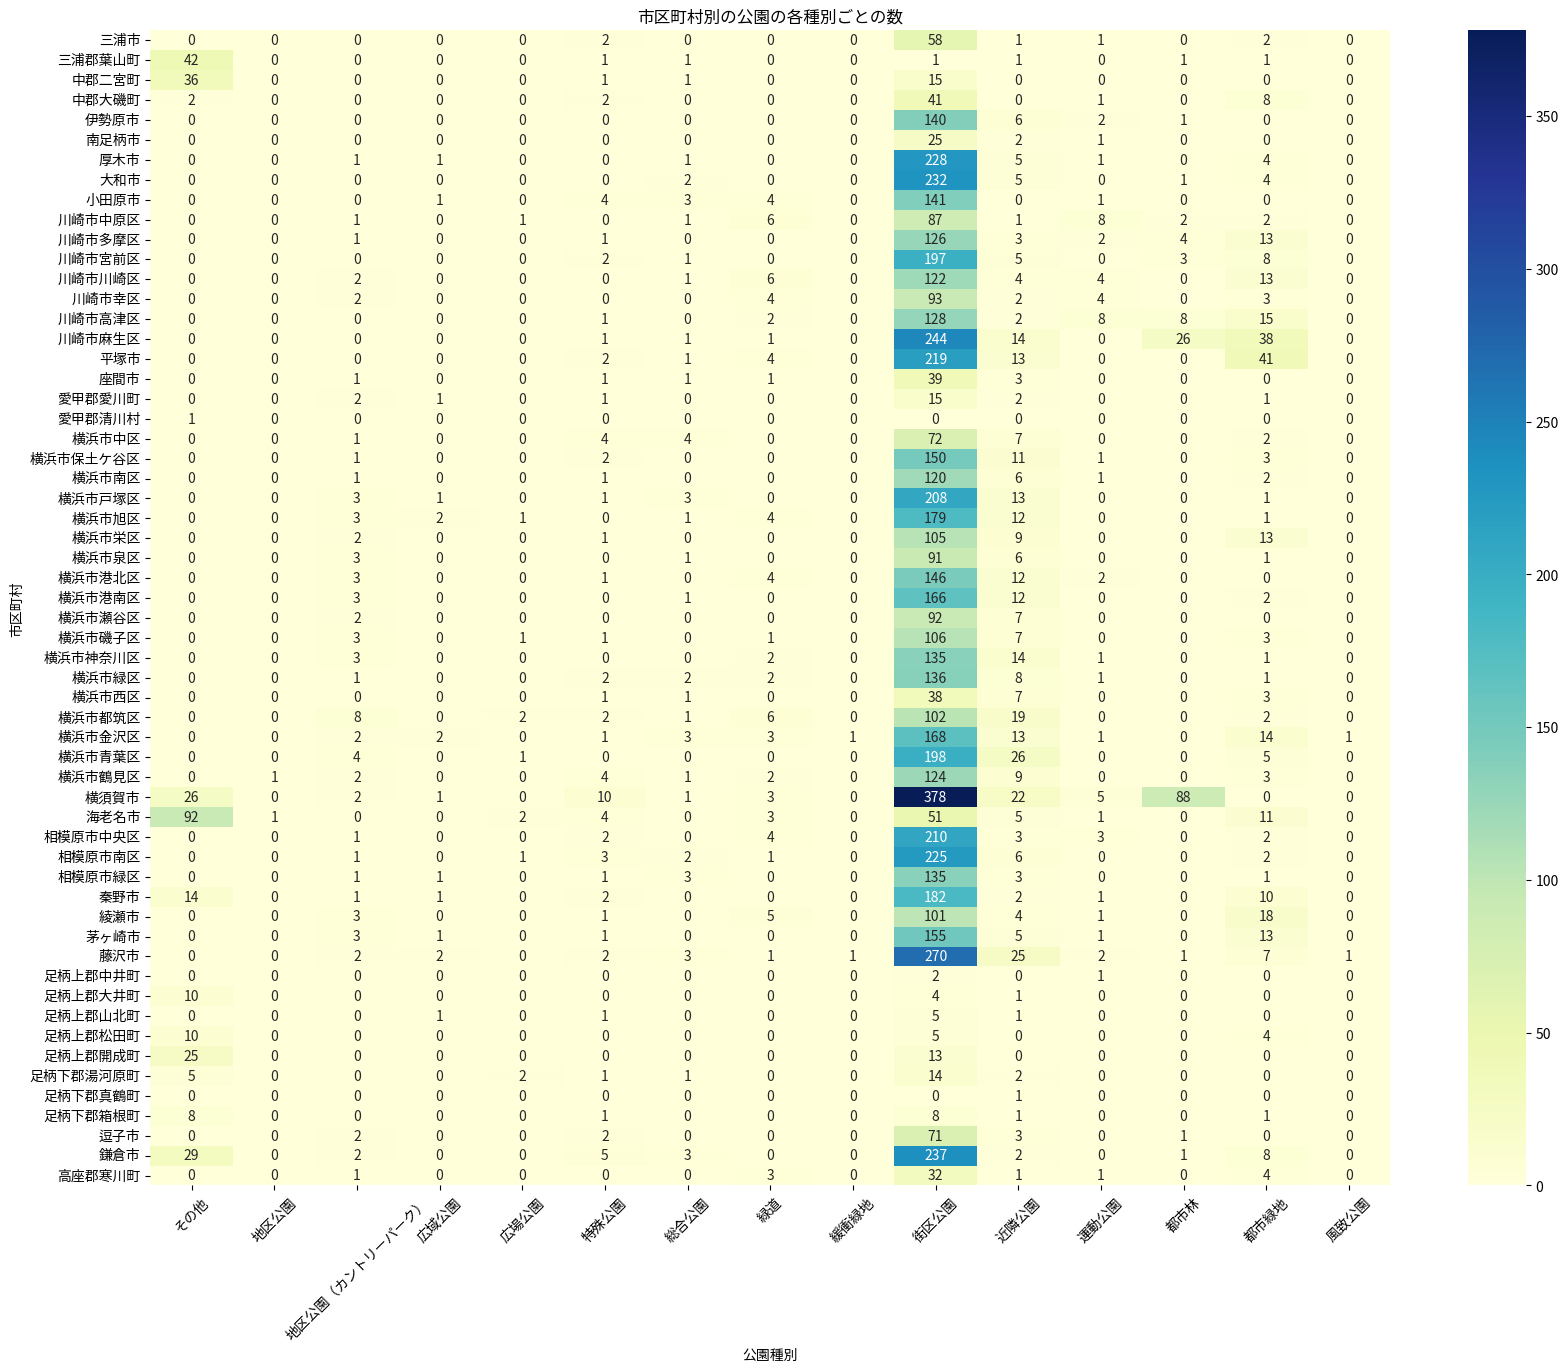

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# 日本語フォントの指定

import matplotlib as mpl

mpl.rcParams['font.family'] = 'Noto Sans CJK JP' 

file_path_1 = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'
# 公園データの読み込み
park_data = pd.read_excel(file_path_1)
#140007_park_(神奈川県公園データ)_修正版.xlsxファイルの「面積」の項目を「公園面積」に変更
park_data['公園種別'] = park_data['公園種別'].replace('特殊公園（風致公園、動植物公園、歴史公園、墓園）', '特殊公園')
# '公園種別'列の値を改行を含む2段表示に変更
# park_data['公園種別'] = park_data['公園種別'].apply(lambda x: str(x).replace('（カントリーパーク）', '\n（カントリーパーク）'))

# '面積' と '提供開始年' を数値に変換
park_data['面積'] = pd.to_numeric(df['面積'], errors='coerce')
park_data['提供開始年'] = pd.to_numeric(df['提供開始年'], errors='coerce')

# 分析 1: 公園種別ごとの公園の数
count_park_type = park_data['公園種別'].value_counts()

# 分析 2: 市区町村別の公園の平均面積
# average_area_by_municipality = park_data.groupby('市区町村')['面積'].mean().sort_values(ascending=False)

# 分析 3: 市区町村別の公園の平均提供開始年
average_year_by_municipality = park_data.groupby('市区町村')['提供開始年'].mean().sort_values(ascending=False)

# 可視化
# plt.figure(figsize=(10, 6))
# count_park_type.plot(kind='bar')
# plt.title('公園種別ごとの公園の数')
# plt.xlabel('公園種別')
# plt.ylabel('数')
# plt.show()
# '面積' 列を数値に変換
park_data['面積'] = pd.to_numeric(df['面積'], errors='coerce')

# NaN 値を含む行を削除
park_data.dropna(subset=['面積'], inplace=True)

# 市区町村別の公園の平均面積を計算
average_area_by_municipality = park_data.groupby('市区町村')['面積'].mean().sort_values(ascending=True)

# 上位10個と下位10個を抽出
top_10 = average_area_by_municipality.tail(10)
bottom_10 = average_area_by_municipality.head(10)

# カラーマッピングの作成
colors = ['green' if municipality in top_10.index else 'red' if municipality in bottom_10.index else 'blue' for municipality in average_area_by_municipality.index]

# 可視化
# 可視化
plt.figure(figsize=(10, 14))
average_area_by_municipality.plot(kind='barh', color=colors)
plt.title('市区町村別の公園の平均面積（緑：面積が多いトップ10、赤：面積が少ないボトム10）')
plt.xlabel('平均面積 (平方メートル)')
plt.ylabel('市区町村')
plt.show()

# plt.figure(figsize=(10, 10))
# average_year_by_municipality.plot(kind='barh')  # 横棒グラフに変更
# plt.xticks(rotation=90, fontsize=8)  # X軸のラベルの回転とフォントサイズ調整
# plt.title('市区町村別の公園の平均提供開始年')
# plt.xlabel('平均提供開始年')
# plt.ylabel('市区町村')
# plt.xlim(1960, 2023)  # 横軸の範囲を1900年から2023年に設定
# plt.show()

# ファイルの読み込み

# df_parks = pd.read_excel(file_path)

# 市区町村と公園種別の関係をクロス集計
park_type_municipality = pd.crosstab(park_data['市区町村'], park_data['公園種別'])

# 可視化
plt.figure(figsize=(20, 15))
sns.heatmap(park_type_municipality, annot=True, fmt="d", cmap="YlGnBu")
plt.title('市区町村別の公園の各種別ごとの数')
plt.xlabel('公園種別')
plt.ylabel('市区町村')
plt.xticks(rotation=45)
# plt.yticks(rotation=45)
plt.show()

In [37]:
#公園種別、所在地、面積、設備
file_path_1 = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版.xlsx'
# 公園データの読み込み
park_data = pd.read_excel(file_path_1)

# 面積列を数値型に変換し、NaNを削除（あるいは別の値で置き換え）
park_data['面積'] = pd.to_numeric(park_data['面積'], errors='coerce')
park_data.dropna(subset=['面積'], inplace=True)  # NaNを含む行を削除

# 公園のカテゴリを定義（例：小規模＜1000平方メートル、中規模＜10000平方メートル、大規模≥10000平方メートル）
def categorize_park(area):
    if area < 1000:
        return '小規模'
    elif area < 10000:
        return '中規模'
    else:
        return '大規模'
    
# 各公園にカテゴリを割り当てる
park_data['カテゴリ'] = park_data['面積'].apply(categorize_park)

# カテゴリ別に公園の数を集計
category_counts = park_data['カテゴリ'].value_counts()

# 結果を表示
print(category_counts)



カテゴリ
小規模    3855
中規模    3465
大規模     703
Name: count, dtype: int64


In [58]:
# データの読み込み
park_data = pd.read_excel(file_path_1)

# 数値に変換する列のリスト
numeric_columns = ['トイレ', '多目的トイレ', '水飲み・手洗い', 'スプリング遊具・スイング遊具', '砂場', '複合遊具', '健康器具', 'ブランコ', 'すべり台', 'ジャングルジム',
                   '鉄棒', 'シーソー', 'ターザンロープ', 'ローラースライダー', 'ふわふわドーム', '芝生広場', '水遊び', 'ランニングコース', 'テニスコート', 'バスケットゴール',
                   '野球場', 'フットサル場', 'サッカー場', 'スケートパーク', 'プール', '体育館', '陸上競技場', 'ウサギ・モルモット', 'ハムスター', 'ひよこ', '馬・ポニー',
                   'カフェ・飲食施設', '売店', '自動販売機', 'バーベキュー場', 'ドッグラン', '喫煙所', 'イベント広場', '避難場所', '無料駐車場', '有料駐車場', '駐輪場']

# 対象の列のみを数値に変換
for column in numeric_columns:
    park_data[column] = pd.to_numeric(park_data[column], errors='coerce')

# 合計の計算（NaN値は無視される）
sums = park_data[numeric_columns].sum()

# 結果の出力
print(sums)




トイレ               1191.0
多目的トイレ             674.0
水飲み・手洗い           5499.0
スプリング遊具・スイング遊具    1120.0
砂場                3362.0
複合遊具              1700.0
健康器具              1002.0
ブランコ              2655.0
すべり台              2768.0
ジャングルジム            395.0
鉄棒                2270.0
シーソー               280.0
ターザンロープ             82.0
ローラースライダー           31.0
ふわふわドーム              9.0
芝生広場               107.0
水遊び                 28.0
ランニングコース            21.0
テニスコート              72.0
バスケットゴール            42.0
野球場                 76.0
フットサル場               4.0
サッカー場               21.0
スケートパーク              6.0
プール                 53.0
体育館                 13.0
陸上競技場               12.0
ウサギ・モルモット            8.0
ハムスター                1.0
ひよこ                  1.0
馬・ポニー                6.0
カフェ・飲食施設            25.0
売店                  32.0
自動販売機              161.0
バーベキュー場             16.0
ドッグラン                8.0
喫煙所                 27.0
イベント広場              31.0
避難場所               341.0
無料駐車場              126.0


KeyError: 'カテゴリ'

In [210]:
# 公園種別のカウント
park_type_counts = park_data['公園種別'].value_counts()
park_location = park_data['市区町村'].value_counts()
print(park_type_counts)
print(park_location)
# フォントプロパティを設定
font_prop = fm.FontProperties(fname=font_path)
# Matplotlibのデフォルトフォントを更新
plt.rcParams['font.family'] = font_prop.get_name()
#神奈川県における公園の種別分布の可視化
# カテゴリ別に集計
category_counts = park_data['公園種別'].value_counts()

# グラフのサイズを設定
plt.figure(figsize=(15, 6))  # グラフのサイズを15x6インチに設定

# 横棒グラフを描画
category_counts.plot(kind='barh', stacked=True)  # 横棒グラフの描画
plt.title('神奈川県における公園の種別分布')
plt.ylabel('公園の種別')
plt.xlabel('公園の数')
plt.xticks(rotation=90, fontsize=8)
plt.show()


公園種別
街区公園                        6589
近隣公園                         354
その他                          300
都市緑地                         291
都市林                          137
特殊公園（風致公園、動植物公園、歴史公園、墓園）      76
地区公園（カントリーパーク）                74
緑道                            74
運動公園                          57
総合公園                          46
広域公園                          15
広場公園                          11
緩衝緑地                           2
地区公園                           2
風致公園                           2
Name: count, dtype: int64
市区町村
神奈川県横浜市           2718
神奈川県川崎市           1224
神奈川県相模原市           610
神奈川県横須賀市           536
神奈川県藤沢市            317
神奈川県鎌倉市            287
神奈川県平塚市            282
神奈川県厚木市            241
神奈川県大和市            240
神奈川県秦野市            213
神奈川県茅ヶ崎市           183
神奈川県海老名市           170
神奈川県小田原市           154
神奈川県伊勢原市           149
神奈川県綾瀬市            133
神奈川県逗子市             79
神奈川県三浦市             63
神奈川県中郡大磯町           54
神奈川県中郡二宮町           53
神奈川県三浦郡葉山町          46
神奈川県座間市  

In [211]:
#神奈川県における公園の種別分布の可視化
# カテゴリ別に集計
category_counts = park_data['公園種別'].value_counts()

# グラフのサイズを設定
plt.figure(figsize=(15, 6))  # グラフのサイズを15x6インチに設定

# 横棒グラフを描画
category_counts.plot(kind='barh', stacked=True)  # 横棒グラフの描画
plt.title('神奈川県における公園の種別分布')
plt.ylabel('公園の種別')
plt.xlabel('公園の数')
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [213]:
#「令和5年7月1日までの全国都道府県市区町村別の面積値」（国土地理院）https://www.gsi.go.jp/KOKUJYOHO/OLD-MENCHO-title.htmを加工して作成
#Excelファイルを読み込む
# file_path = '/home/yasumasa-tezuka/intern_data/R1_R5_all_mencho.xlsx'  # ここに元のファイルのパスを入力
# df = pd.read_excel(file_path)
# print(df.columns)
# # 特定の行と列を選択（例：1行目から5行目まで、列'A'と'B'）
# selected_data = df.loc[885:960, ['都道府県','市区町村', '令和5年7月1日(k㎡)']]

# # 選択したデータを新しいExcelファイルに保存
# selected_data.to_excel('area.xlsx', index=False)

In [214]:
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import geopandas as gpd

from geopy.exc import GeocoderTimedOut

def get_coordinates(address, attempt=1, max_attempts=3):
    geolocator = Nominatim(user_agent="your_app_name", timeout=10)  # タイムアウトを延長
    try:
        location = geolocator.geocode(address)
        if location:
            return Point(location.longitude, location.latitude)
        else:
            return None
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return get_coordinates(address, attempt + 1, max_attempts)
        return None

In [295]:
# 公園データの読み込み
file_path_1 = '/home/yasumasa-tezuka/intern_data/(神奈川県公園データ)_短縮版.xlsx'
park_data = pd.read_excel(file_path_1)
# #人口密度
file_path_2 = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10.xlsx'
# #行政区域の面積
file_path_3 = '/home/yasumasa-tezuka/intern_data/administrative_area.xlsx'

#公園データの集計
# 公園面積のデータを数値に変換（数値以外の値はNaNに置き換え）
park_data['公園面積'] = pd.to_numeric(park_data['公園面積'], errors='coerce')

# NaNを0で置き換え
park_data['公園面積'] = park_data['公園面積'].fillna(0)

# 各市区町村ごとに公園の数と面積の合計を集計
parks_summary = park_data.groupby('市区町村').agg({'名称': 'count', '公園面積': 'sum'}).rename(columns={'名称': '公園数'})

#データの結合
# 人口密度データと市区町村エリアデータの結合
combined_data = pd.merge(population_density, administrative_area, on='市区町村', how='left')

high_density_areas = combined_data[combined_data['人口密度'] >= median_population_density]
low_density_areas = combined_data[combined_data['人口密度'] < median_population_density]

# それぞれの地域の公園数と公園面積の平均を計算
high_density_parks_avg = high_density_areas[['公園数', '公園面積']].mean()
low_density_parks_avg = low_density_areas[['公園数', '公園面積']].mean()

# 人口密度の中央値と、高密度地域・低密度地域での公園数と公園面積の平均を表示(小数点以下2桁で表示)
print(f"人口密度の中央値: {median_population_density:.2f} 人/km²")

print("\n高密度地域の公園の状況:")
print(f"平均公園数: {high_density_parks_avg['公園数']:.2f} 個")
print(f"平均公園面積: {high_density_parks_avg['公園面積']:.2f} m²")

print("\n低密度地域の公園の状況:")
print(f"平均公園数: {low_density_parks_avg['公園数']:.2f} 個")
print(f"平均公園面積: {low_density_parks_avg['公園面積']:.2f} m²")

# 下記の分析結果から、以下の点がわかります：

# 人口密度と公園の数量:

# 人口密度が高い地域では公園の数が多い傾向があります。これは人口密度が高い地域でレクリエーションスペースや緑地の需要が高いため、より多くの公園が設置されている可能性を示唆しています。
# 人口密度と公園の面積:

# 人口密度が低い地域では、公園の平均面積が高い傾向が見られます。これは、人口密度が低い地域では土地が広く、大きな公園を設置するスペースがあるためかもしれません。
# 結合データに公園の集計データを結合
combined_data = pd.merge(combined_data, parks_summary, on='市区町村', how='left')

# 公園の数と面積がNaNの場合を0に置換
combined_data['公園数'] = combined_data['公園数'].fillna(0)
combined_data['公園面積'] = combined_data['公園面積'].fillna(0)

#人口密度にもとづく分析
# 人口密度の中央値を計算
median_population_density = combined_data['人口密度'].median()

# 人口密度が中央値以上の地域（高密度地域）と以下の地域（低密度地域）に分ける

人口密度の中央値: 6343.86 人/km²

高密度地域の公園の状況:
平均公園数: 139.24 個
平均公園面積: 804239.93 m²

低密度地域の公園の状況:
平均公園数: 109.97 個
平均公園面積: 887851.03 m²


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 高密度地域と低密度地域の平均公園数と公園面積のデータを取得
categories = [high_density_areas, low_density_areas]
park_counts = [high_density_parks_avg['公園数'], low_density_parks_avg['公園数']]
park_areas = [high_density_parks_avg['公園面積'], low_density_parks_avg['公園面積']]

# x軸の位置を設定
x = np.arange(len(categories))

# グラフの作成
fig, ax1 = plt.subplots(figsize=(15, 6))

# 公園数の棒グラフ
ax1.bar(x - 0.2, park_counts, 0.4, label='平均公園数', color='b')

# 公園面積の棒グラフ
ax2 = ax1.twinx()  # 共有x軸を持つ別のy軸を作成
ax2.bar(x + 0.2, park_areas, 0.4, label='平均公園面積', color='g')

# タイトルと軸ラベルの設定
ax1.set_xlabel('地域')
ax1.set_ylabel('平均公園数')
ax2.set_ylabel('平均公園面積 (m²)')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
plt.title('高密度地域と低密度地域の公園の状況比較')

# 凡例の表示
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# グラフの表示
plt.show()


NameError: name 'high_density_areas' is not defined

<Figure size 1000x1000 with 0 Axes>

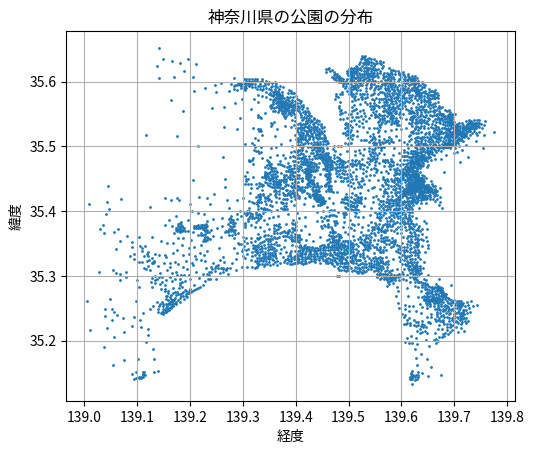

   トイレ 多目的トイレ 無料駐車場 有料駐車場  公園数
0    0      0     0     0  283
1    0      0     0     1    2
2    0      0     1     0    4
3    0      0     1     1    1
4    0      0     -     -  353
5    0      1     0     0    3
6    1      0     0     0   53
7    1      0     0     1    2
8    1      0     1     0   13
9    1      0     -     1    3
10   1      0     -     -  111
11   1      1     0     0   53
12   1      1     0     1   35
13   1      1     1     0   77
14   1      1     1     1   17
15   1      1     -     1   31
16   1      1     -     -  211
17   2      2     1     0    1
18   -      -     -     -   11


In [85]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# CSVファイルのパス
csv = '/home/yasumasa-tezuka/intern_data/公園位置情報.csv'
csv_data = pd.read_csv(csv, encoding='shift_jis')

# CSVデータから緯度と経度の列を使用してGeoDataFrameを作成
gdf = gpd.GeoDataFrame(
    csv_data, 
    geometry=gpd.points_from_xy(csv_data.経度, csv_data.緯度)
)

# CRSを設定（日本の座標系）
gdf.set_crs(epsg=4326, inplace=True)

# 公園の分布を可視化
plt.figure(figsize=(10, 10))
gdf.plot(markersize=1)
plt.title("神奈川県の公園の分布")
plt.xlabel("経度")
plt.ylabel("緯度")
plt.grid(True)
plt.show()

# Excelデータから利便設備に関する列を選択
facilities = park_data[['名称', 'トイレ', '多目的トイレ', '無料駐車場', '有料駐車場']]

# 各設備の有無に基づいてグループ化し、カウント
facility_counts = facilities.groupby(['トイレ', '多目的トイレ', '無料駐車場', '有料駐車場']).size().reset_index(name='公園数')

# 結果の表示
print(facility_counts)

# 利便設備が存在する公園の地理的分布を可視化
# ここでは例としてトイレがある公園をプロット
# toilet_available = csv_data[csv_data.市区町村名.isin(park_data[park_data['トイレ'] == 1]['名称'])]
# gdf_toilet = gpd.GeoDataFrame(
#     toilet_available, 
#     geometry=gpd.points_from_xy(toilet_available.経度, toilet_available.緯度)
# )

# # 可視化
# plt.figure(figsize=(10, 10))
# gdf_toilet.plot(markersize=2)
# plt.title("トイレがある公園の分布")
# plt.xlabel("経度")
# plt.ylabel("緯度")
# plt.grid(True)
# plt.show()


/home/yasumasa-tezuka/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yasumasa-tezuka/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yasumasa-tezuka/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/yasumasa-tezuka/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

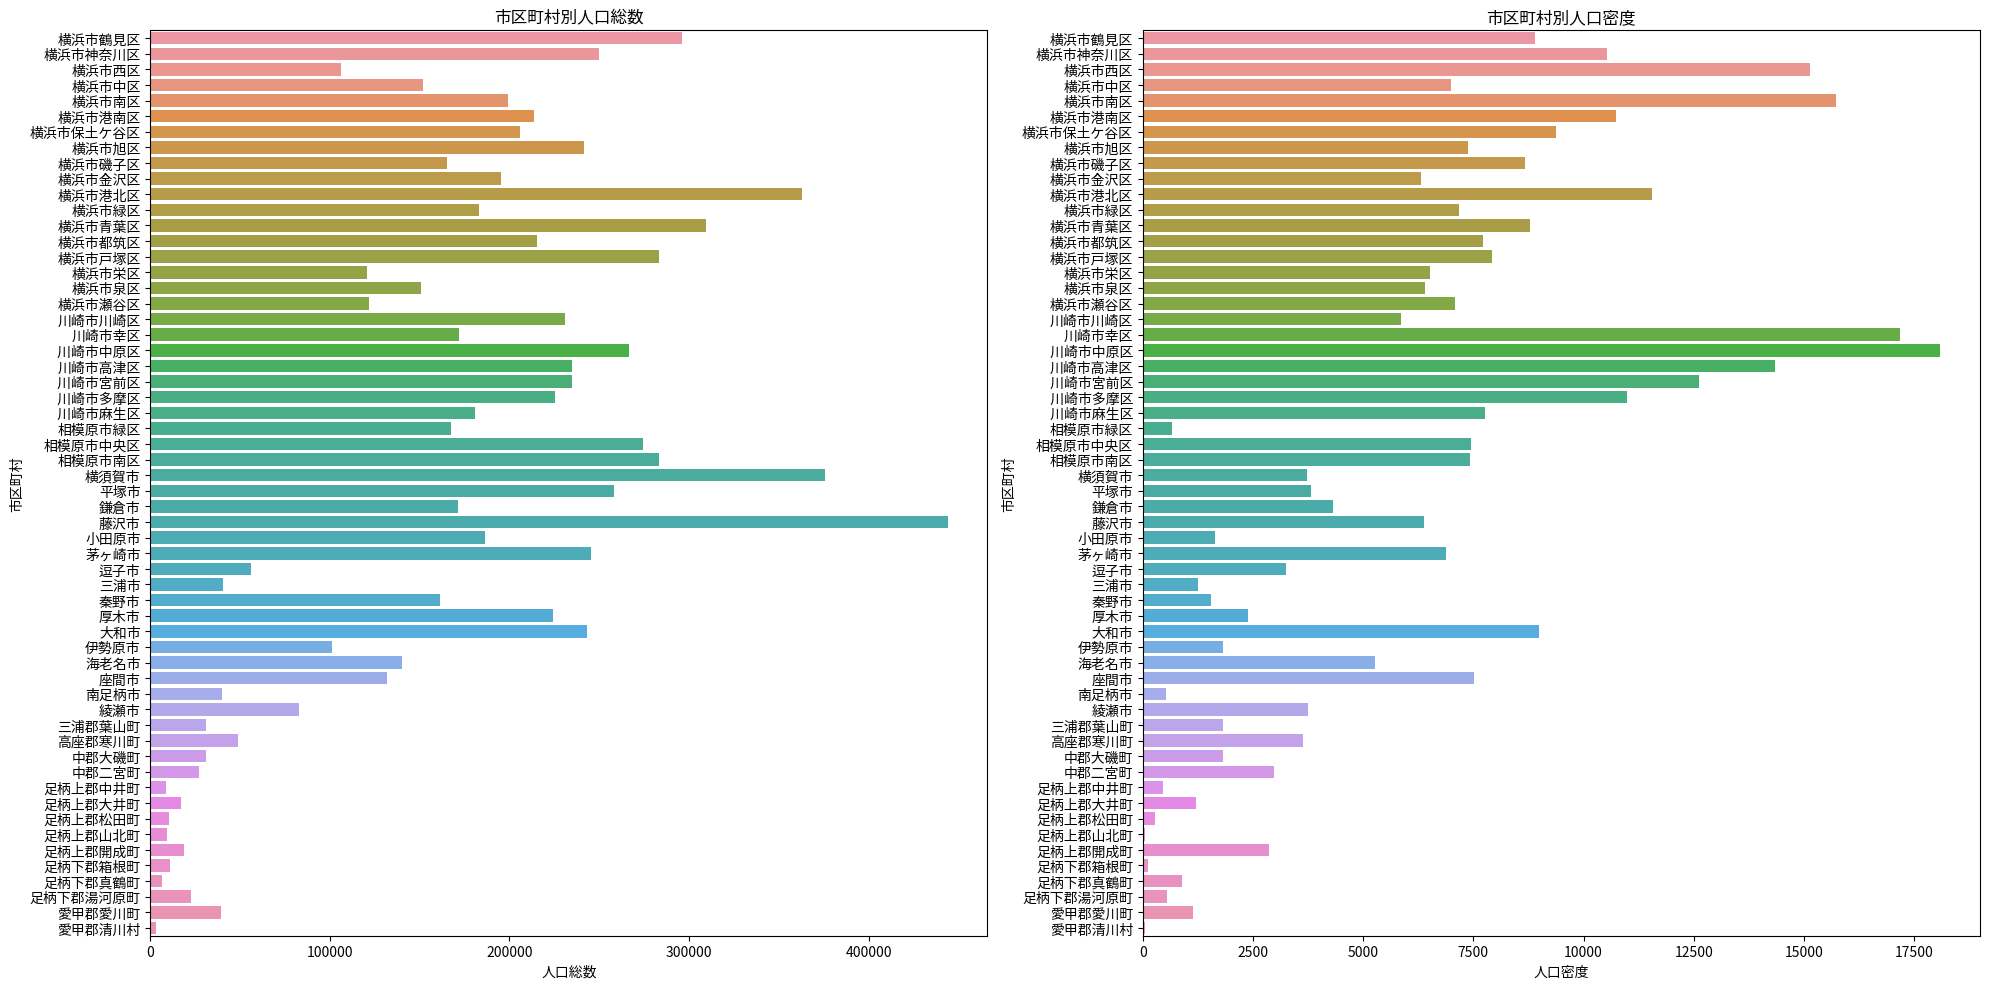

In [294]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the uploaded Excel file
file_path_2 = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10.xlsx'
data = pd.read_excel(file_path_2)

# Convert '人口総数' and '人口密度' to numeric values, if not already
data['人口総数'] = pd.to_numeric(data['人口総数'], errors='coerce')
data['人口密度'] = pd.to_numeric(data['人口密度'], errors='coerce')

# Remove rows with NaN values in these columns
data.dropna(subset=['人口総数', '人口密度'], inplace=True)

# Setting up the plot
plt.figure(figsize=(20, 10))

# Plotting population
plt.subplot(1, 2, 1)
sns.barplot(x='人口総数', y='市区町村', data=data)
plt.title('市区町村別人口総数')
plt.xlabel('人口総数')
plt.ylabel('市区町村')

# Plotting population density
plt.subplot(1, 2, 2)
sns.barplot(x='人口密度', y='市区町村', data=data)
plt.title('市区町村別人口密度')
plt.xlabel('人口密度')
plt.ylabel('市区町村')

# Show the plot
plt.tight_layout()
plt.show()


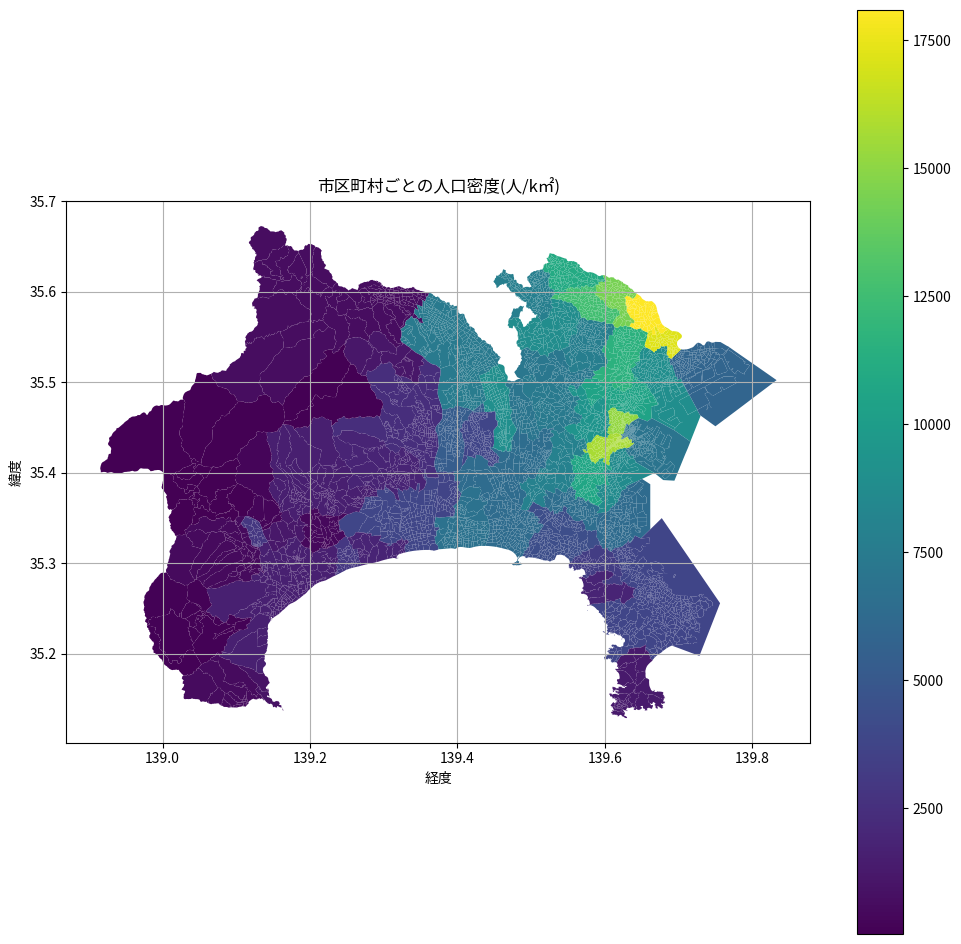

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# 市区町村の境界シェープファイルの読み込み
# boundary_file_path = '/home/yasumasa-tezuka/intern_data/境界令和4年/r2ka14.shp'  # 例: 'boundary.shp'
# boundary_gdf = gpd.read_file(boundary_file_path)

# # 境界データのプロット
# fig, ax = plt.subplots(figsize=(10, 10))
# boundary_gdf.plot(ax=ax)
# plt.title('市区町村の境界')
# plt.xlabel('経度')
# plt.ylabel('緯度')
# plt.grid(True)
# plt.show()

# #人口密度
file_path_2 = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10_2.xlsx'
population_density = pd.read_excel(file_path_2)

# 'CITY' 列を文字列型に変換
boundary_gdf['CITY'] = boundary_gdf['CITY'].astype(str)
population_density['CITY'] = population_density['CITY'].astype(str)

# 人口密度データを市区町村の境界データと結合
combined_gdf = pd.merge(boundary_gdf, population_density, on='CITY', how='left')

# 人口密度に基づいたマップの作成
fig, ax = plt.subplots(figsize=(12, 12))
combined_gdf.plot(ax=ax, column='人口密度', legend=True, cmap='viridis')

plt.title('市区町村ごとの人口密度(人/k㎡)')
plt.xlabel('経度')
plt.ylabel('緯度')
plt.grid(True)
plt.show()

#人口密度の上に公園の分布→失敗に終わった

In [55]:
#多変量解析（クラスター分析）、主成分分析、回帰分析
#前処理(jinkotosetai_r5_10_３.xlsx)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# ファイルの読み込み
file_path = '/home/yasumasa-tezuka/intern_data/jinkotosetai_r5_10_３.xlsx'
df = pd.read_excel(file_path)

# 不要な列の削除
df_processed = df.drop(columns=['CITY'])

# 欠損値の確認（このケースでは欠損値はありませんでした）
missing_values = df_processed.isnull().sum()

# 数値データの正規化
scaler = MinMaxScaler()
numerical_cols = ['市区町村別面積(k㎡)', '世帯', '人口総数', '人口密度']
df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])

# 処理後のデータの表示
processed_head = df_processed.head()

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# データの読み込み
file_path = '/home/yasumasa-tezuka/intern_data/140007_park_(神奈川県公園データ)_修正版改.xlsx'
park_data = pd.read_excel(file_path)

# 大多数の欠損値を持つ列の削除
missing_values = park_data.isnull().sum()
columns_to_drop = missing_values[missing_values > 100].index
park_data_cleaned = park_data.drop(columns=columns_to_drop)

# ブール型の列の欠損値を「0」で埋める
boolean_columns = ['トイレ', '多目的トイレ', '水飲み・手洗い']
park_data_cleaned[boolean_columns] = park_data_cleaned[boolean_columns].fillna(0)

# 重要な情報を含む列の欠損値を持つ行の削除
important_columns = ['自治体名', '所在地', '公園面積', '公園種別', '市区町村']
park_data_cleaned = park_data_cleaned.dropna(subset=important_columns)

# カテゴリ変数のエンコーディング
label_encoder = LabelEncoder()
categorical_columns = ['自治体名', '公園種別', '市区町村']
for column in categorical_columns:
    park_data_cleaned[column] = label_encoder.fit_transform(park_data_cleaned[column])